Import libraries and load data into pandas dataframe

In [148]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import logging
logging.getLogger().setLevel(logging.INFO)

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

#Loading data
got_dataframe = pd.read_csv("./character-predictions.csv", sep=",",na_values=[])
got_dataframe.fillna(0, inplace=True)

Save the characters that we want to predict

In [149]:
wantToPredict = got_dataframe.loc[got_dataframe['S.No'].isin([1467,1475,1476,1684,1926,1508,1510,1712,1795,1750,1597,274,1793,1839])]
wantToPredict = wantToPredict[['popularity','male','book1','book2','book3','book4','book5','isMarried','isNoble','isAlive']]
display.display(wantToPredict)

,popularity,male,book1,book2,book3,book4,book5,isMarried,isNoble,isAlive
273,1.0,1,1,1,1,1,1,0,0,1
1466,1.0,0,1,1,1,1,1,0,1,1
1474,1.0,1,1,1,1,1,1,0,1,1
1475,0.5,1,1,1,1,1,1,1,1,1
1507,0.1,0,0,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1749,1.0,1,1,1,1,1,1,0,1,1
1792,1.0,0,1,1,1,1,1,1,1,1
1794,0.2,1,0,0,0,0,0,0,0,1
1838,0.2,1,0,0,1,1,1,0,1,1


In [150]:
got_dataframe = got_dataframe.reindex(np.random.permutation(got_dataframe.index))
got_dataframe = got_dataframe[['title','male','culture','mother','father','house','spouse','book1','book2','book3','book4','book5','isMarried','isNoble','age','numDeadRelations','popularity','isPopular','isAlive']]
display.display(got_dataframe.describe())
got_dataframe.head()

#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

,male,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,popularity,isPopular,isAlive
count,1946.0,1946.0,1946.0,1946.0,1946.0,1946.0,1946.0,1946.0,1946.0,1946.0,1946.0,1946.0,1946.0
mean,0.6,0.2,0.4,0.5,0.6,0.4,0.1,0.5,-287.8,0.3,0.1,0.1,0.7
std,0.5,0.4,0.5,0.5,0.5,0.5,0.3,0.5,9236.0,1.4,0.2,0.2,0.4
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-298001.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
75%,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.1,0.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,15.0,1.0,1.0,1.0


,title,male,culture,mother,father,house,spouse,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,popularity,isPopular,isAlive
184,0,0,0,0,0,Peach,0,0,0,1,1,0,0,0,0.0,0,0.0,0,1
1727,High Septon,1,0,0,0,Faith of the Seven,0,0,0,0,1,1,0,1,0.0,0,0.2,0,1
204,0,1,Free Folk,0,0,0,0,0,0,1,1,1,0,0,0.0,0,0.0,0,1
1450,Maidenpool,1,0,0,0,House Mooton,0,0,1,1,1,1,0,1,0.0,0,0.0,0,1
1628,Brightwater,1,0,0,0,House Florent,Melara Crane,0,1,1,0,1,1,1,0.0,0,0.3,0,0


Define some functions:

In [151]:
def normalizeColumnNames(dataframe):
    dataframe.columns = [x.replace("'", "") for x in dataframe.columns]
    dataframe.columns = [x.replace(" ", "") for x in dataframe.columns]
    return dataframe

In [152]:
def preprocess_features(got_dataframe):
  #selected_features = pd.concat([got_dataframe[['popularity','male','book1','book2','book3','book4','book5','isMarried','isNoble']],got_dataframe[[col for col in got_dataframe if col.startswith('norm_house')]] ],axis=1)
  selected_features = got_dataframe[['popularity','male','book1','book2','book3','book4','book5','isMarried','isNoble']]
  processed_features = selected_features.copy()
  return processed_features

def preprocess_targets(got_dataframe):
  output_targets = pd.DataFrame()
  output_targets["isAlive"] =  got_dataframe["isAlive"]
  return output_targets

Define our trainig and validation features:

In [153]:
training_examples = preprocess_features(pd.concat([got_dataframe.head(1200),normalizeColumnNames(pd.get_dummies(got_dataframe[['house']],sparse=False, prefix=['norm_house'])).head(1200)], axis=1))
training_targets = preprocess_targets(got_dataframe.head(1200))

validation_examples = preprocess_features(pd.concat([got_dataframe.tail(746),normalizeColumnNames(pd.get_dummies(got_dataframe[['house']],sparse=False, prefix=['norm_house'])).tail(746)], axis=1))
validation_targets = preprocess_targets(got_dataframe.tail(746))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,popularity,male,book1,book2,book3,book4,book5,isMarried,isNoble
count,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0
mean,0.1,0.6,0.2,0.4,0.5,0.6,0.4,0.1,0.5
std,0.1,0.5,0.4,0.5,0.5,0.5,0.5,0.3,0.5
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
75%,0.1,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Validation examples summary:


,popularity,male,book1,book2,book3,book4,book5,isMarried,isNoble
count,746.0,746.0,746.0,746.0,746.0,746.0,746.0,746.0,746.0
mean,0.1,0.6,0.2,0.4,0.5,0.6,0.4,0.1,0.5
std,0.2,0.5,0.4,0.5,0.5,0.5,0.5,0.4,0.5
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
75%,0.1,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Training targets summary:


,isAlive
count,1200.0
mean,0.7
std,0.4
min,0.0
25%,0.0
50%,1.0
75%,1.0
max,1.0


Validation targets summary:


,isAlive
count,746.0
mean,0.8
std,0.4
min,0.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [154]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [155]:
training_examples.describe()

,popularity,male,book1,book2,book3,book4,book5,isMarried,isNoble
count,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0,1200.0
mean,0.1,0.6,0.2,0.4,0.5,0.6,0.4,0.1,0.5
std,0.1,0.5,0.4,0.5,0.5,0.5,0.5,0.3,0.5
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
75%,0.1,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [156]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    targetLabel="isAlive"):

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["isAlive"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["isAlive"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["isAlive"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

In [157]:
#_ = training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)
print(len(training_examples.columns))
print("-----")
print(len(training_targets.columns))
print("-----")
print(len(training_examples.columns))
print("-----")
print(len(validation_targets.columns))

9
-----
1
-----
9
-----
1


In [158]:

'''dnn_regressor = train_nn_regression_model(
    learning_rate=0.005,
    steps=500,
    batch_size=10,
    hidden_units=[2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)'''

'dnn_regressor = train_nn_regression_model(\n    learning_rate=0.005,\n    steps=500,\n    batch_size=10,\n    hidden_units=[2],\n    training_examples=training_examples,\n    training_targets=training_targets,\n    validation_examples=validation_examples,\n    validation_targets=validation_targets)'

Let's try with a classifier

In [159]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=constructed_features,
    hidden_units=[10, 5],
    optimizer=tf.train.ProximalAdagradOptimizer(
      learning_rate=0.1,
      l1_regularization_strength=0.001
    ))

def my_input_fn_classify(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(100000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels
    #return {'x': features}, labels



classifier.train(input_fn= lambda: my_input_fn_classify(training_examples, training_targets["isAlive"], batch_size=10), steps=1000)

print("\nModel trained")


Model trained


In [160]:
# Evaluate accuracy
accuracy_score = classifier.evaluate(input_fn= lambda: my_input_fn_classify(validation_examples, validation_targets["isAlive"],num_epochs=1,shuffle=False))["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))


Test Accuracy: 78.820378%



Create a correlation matrix

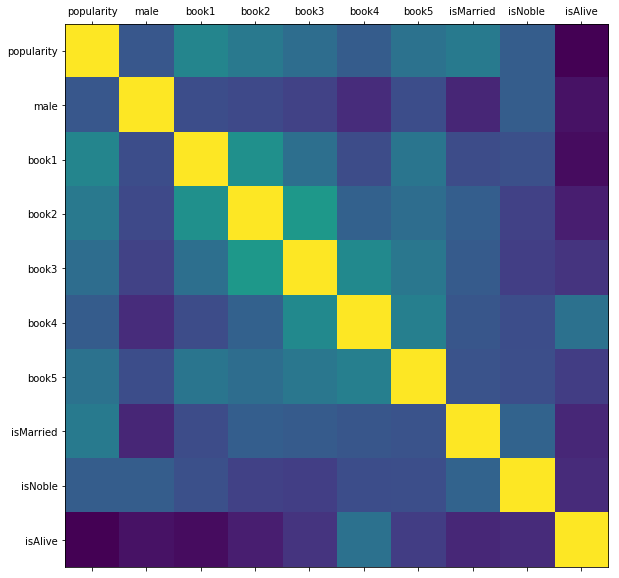

In [161]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

plot_corr(pd.concat([training_examples,training_targets], axis=1))

Let's take these fucking predictions man!

In [162]:
a = tf.estimator.inputs.pandas_input_fn(
            x=wantToPredict,
            num_epochs=1,
            shuffle=False,
            target_column='isAlive'
        )
a()

{'popularity': <tf.Tensor 'fifo_queue_DequeueUpTo_3:1' shape=(?,) dtype=float64>,
 'male': <tf.Tensor 'fifo_queue_DequeueUpTo_3:2' shape=(?,) dtype=int64>,
 'book1': <tf.Tensor 'fifo_queue_DequeueUpTo_3:3' shape=(?,) dtype=int64>,
 'book2': <tf.Tensor 'fifo_queue_DequeueUpTo_3:4' shape=(?,) dtype=int64>,
 'book3': <tf.Tensor 'fifo_queue_DequeueUpTo_3:5' shape=(?,) dtype=int64>,
 'book4': <tf.Tensor 'fifo_queue_DequeueUpTo_3:6' shape=(?,) dtype=int64>,
 'book5': <tf.Tensor 'fifo_queue_DequeueUpTo_3:7' shape=(?,) dtype=int64>,
 'isMarried': <tf.Tensor 'fifo_queue_DequeueUpTo_3:8' shape=(?,) dtype=int64>,
 'isNoble': <tf.Tensor 'fifo_queue_DequeueUpTo_3:9' shape=(?,) dtype=int64>,
 'isAlive': <tf.Tensor 'fifo_queue_DequeueUpTo_3:10' shape=(?,) dtype=int64>}

In [170]:
def input_fn_predict(df_data):
    
        return tf.estimator.inputs.pandas_input_fn(
            x=df_data,
            num_epochs=1,
            shuffle=False,
            target_column='isAlive'
        )
    
predictions = classifier.predict(input_fn=input_fn_predict(wantToPredict))
#print(list(predictions))
for pred_dict in predictions:
        template = ('\nPrediction is "{}" ({:.1f}%)')

        class_id = pred_dict['class_ids'][0]
        probability = pred_dict['probabilities'][class_id]

        print(template.format(class_id,100 * probability))



Prediction is "0" (53.5%)

Prediction is "1" (67.3%)

Prediction is "0" (50.4%)

Prediction is "1" (55.6%)

Prediction is "1" (88.0%)

Prediction is "1" (87.8%)

Prediction is "1" (68.5%)

Prediction is "0" (52.5%)

Prediction is "1" (78.2%)

Prediction is "0" (50.4%)

Prediction is "1" (61.7%)

Prediction is "0" (53.5%)

Prediction is "1" (78.7%)

Prediction is "0" (50.7%)


These are the predictions for these characters:

1467-Arya Stark
1475-Bran Stark
1476-Bronn
1684-Davos Seaworth
1926-Gendry
1508-Ghost of High Heart
1510-Gilly
1712-Grey Worm
1795-Jaqen H'ghar
1750-Jon Snow
1597-Podrick Payne
274-Samwell Tarly
1793-Sansa Stark
1839-Tormund
